In [1]:
import rasterio
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from rasterio.features import geometry_mask

In [2]:
import xarray as xr
from xarray_selafin.xarray_backend import SelafinBackendEntrypoint

In [3]:
from scipy.spatial import cKDTree

In [4]:
def make_ocean_mask(dem_tile, coastline_file):
    # retrieve coordinate system
    with rasterio.open(dem_tile) as src:
        dem_crs = src.crs

    # retrieve coastline and reproject
    coastline = gpd.read_file('WolfNeckFinal.kml')
    coastline = coastline.to_crs(dem_crs)

    # Create a mask for ocean areas
    with rasterio.open(dem_tile) as src:
        dem_data = src.read(1)
        transform = src.transform
    
        # rasterize the coast polygon
        # mask=True means ocean True, land False
        ocean_mask = geometry_mask(
                coastline.geometry,
                out_shape=dem_data.shape,
                transform=transform, # from src above
                invert=True # true where polygon exists (ocean)
        )
    return ocean_mask, transform

In [5]:
 def diGraph_from_dem(dem_path,ocean_mask,ocean_level=-10.0,cell_size=1.0):
     
    """
    Builds a directed graph from a LiDAR-derived DEM (TIFF)
    
    Args: 
        dem_path (str): Path to the DEM TIFF file
        cell_size (float): size of DEM cell
        connectivity (int): assumes 8 - cardinals plus diagonals
    
    Returns:
        graph (nx.DiGraph): a directed graph such that each node
            corresponds to a dem cell from the raster with:
            - node attributes:
                - elev (float): the elevation of the cell
                - isPit (boolean): marking cell as pit (no outlet)
                - isSource (boolean): marking as source (no inlet)
                - node_idx (int, int): indices of the node on the dem tile
            - edge attributes:
                - weight (float): absolute value of slope between two nodes
    
    Terms:
        pit - node with no neighbors lower than itself and at least one higher
        source - node with no neighbors lower than itself and at least one lower
    
    """

    with rasterio.open(dem_path) as src:
        dem_data = src.read(1)
        height, width = dem_data.shape

    # set ocean cells to very low (and uniform) elevation
    # will enforce pit creation precisely at boundary
    # and no source/sink/node creation in ocean
    dem_data[ocean_mask] = - 10.0
    
    num_nodes = height*width
    graph = nx.DiGraph()
    

    # track pit and source nodes
    coastPitList = []
    sourceList = []
    
    # assuming cardinal and diagonal neighbors
    neighbors = [(-1,0), (1,0), (0,1), (0,-1),
                 (-1,-1), (-1,1), (1,-1), (1,1)]
    
    
    
    for r in range(height):
        for c in range(width):
            current_node_idx = r * width + c # iterates through num_nodes
            # Add node with attributes
            graph.add_node(current_node_idx, 
                           dem_idx=[r,c], 
                           elev=dem_data[r,c],
                           is_coastPit=False,
                           is_source=False)

            minSlope = 0
            maxSlope = 0
            next_node = current_node_idx
            
            for dr, dc in neighbors:
                nr, nc = r + dr, c + dc
    
                if 0 <= nr < height and 0 <= nc < width: # check nr, nc in bounds
                    neighbor_node_idx = nr*width + nc # index in lil_matrix
                    
                    # neigbor - center: negative implies downslope from center
                    slope = dem_data[nr,nc] - dem_data[r,c]
                    slope = slope / (np.linalg.norm([dr,dc])*cell_size) # normalize
                    
                    if slope < minSlope:
                        minSlope = slope
                        next_node = neighbor_node_idx
                    elif slope > maxSlope:
                        maxSlope = slope
                        
            
            #after looping through neighbors of r,c
            if minSlope < 0:
                wgt = abs(minSlope)
                graph.add_edge(current_node_idx, next_node, weight=wgt)
                if maxSlope == 0: # outflow + no inflow = source
                    graph.nodes[current_node_idx]["is_source"] = True
                    sourceList.append(current_node_idx)
            elif minSlope == 0 and maxSlope > 0 and dem_data[r,c] == ocean_level: 
                # coastPit: no outlets, has inflow, has reached ocean:
                    graph.nodes[current_node_idx]["is_coastPit"] = True
                    coastPitList.append(current_node_idx)

        

                    
    
                    
    print("pit count: " + str(len(coastPitList)))
    print("sourceList: " + str(len(sourceList)))
    return graph, coastPitList, sourceList, dem_data

In [6]:
# r convert normal string to raw string
dem_file = "smallBluff1.tif"

In [7]:
coast_file = 'WolfNeckFinal.kml'

In [8]:
ocean_mask, transform = make_ocean_mask(dem_file, coast_file)

In [9]:
wolfGraph, coastPitList, sourceList, dem_data = diGraph_from_dem(dem_file, ocean_mask)

pit count: 453
sourceList: 1039


In [10]:
def trace_tree_from_pit(graph, pit_node, max_depth=1000):
    """
    Traces all upstream nodes that flow into the given pit.
    
    Args:
        graph: NetworkX DiGraph
        pit_node: Starting node (pit/outlet)
        max_depth: Maximum number of nodes to prevent infinite loops
        
    Returns:
        subgraph: Subgraph containing the tree
    """
    visited = set()
    to_visit = [pit_node]
    
    while to_visit and len(visited) < max_depth:
        current = to_visit.pop(0)
        
        if current in visited:
            continue
            
        visited.add(current)
        
        # Get all nodes that flow INTO current node
        predecessors = list(graph.predecessors(current))
        to_visit.extend(predecessors)
    
    # Create subgraph from visited nodes
    tree_subgraph = graph.subgraph(visited).copy()
    
    # print(f"Tree has {len(visited)} nodes")
    return tree_subgraph

pit0 = coastPitList[0]
print(f'first pit: {pit0}')
node_list = [pit0]
print(node_list)

max_depth = 1000
pit0 = coastPitList[400]
pitTree = trace_tree_from_pit(wolfGraph, pit0, max_depth)

In [11]:
# import selafin file
ds = xr.open_dataset('3DWolfsCoveApr20.slf', engine='selafin')

# verify
print(ds)
print(f"\nDimensions: {ds.dims}")
print(f"\nVariables: {list(ds.data_vars)}")
print(f"\nCoordinates: {list(ds.coords)}")
print(f"X range: {ds.x.min().values} to {ds.x.max().values}")
print(f"Y range: {ds.y.min().values} to {ds.y.max().values}")

The IPOBO array seems corrupted (zeros array). Try to rebuild it with `build_ipobo()`.


<xarray.Dataset> Size: 4GB
Dimensions:   (time: 4465, plan: 4, node: 10763)
Coordinates:
    x         (node) float32 43kB ...
    y         (node) float32 43kB ...
  * time      (time) datetime64[ns] 36kB 1900-01-01 ... 1900-02-01
Dimensions without coordinates: plan, node
Data variables:
    Z         (time, plan, node) float32 769MB ...
    U         (time, plan, node) float32 769MB ...
    V         (time, plan, node) float32 769MB ...
    W         (time, plan, node) float32 769MB ...
    SALINITY  (time, plan, node) float32 769MB ...
Attributes:
    title:       Example_telemac_07Oct2025
    language:    en
    float_size:  4
    endian:      >
    params:      (1, 0, 0, 0, 0, 0, 4, 0, 0, 0)
    ipobo:       [0 0 0 ... 0 0 0]
    ikle2:       [[    1     2     3]\n [    1     3     8]\n [    1    15   ...
    ikle3:       [[    1     2     3 10764 10765 10766]\n [    1     3     8 ...
    variables:   {'Z': ('ELEVATION Z', 'M'), 'U': ('VELOCITY U', 'M/S'), 'V':...
    date_start:

In [13]:
# test one pit
test_pit = coastPitList[0]
r, c = wolfGraph.nodes[test_pit]['dem_idx']
pit_x, pit_y = rasterio.transform.xy(transform, r, c)

print(f"pit location: ({pit_x:.1f},{pit_y:.1f})")
print(f"TELEMAC X range: {ds.x.min().values:.1f} to {ds.x.max().values:.1f}")
print(f"TELEMAC Y range: {ds.y.min().values:.1f} to {ds.y.max().values:.1f}")

pit location: (413499.5,4853587.5)
TELEMAC X range: 408782.8 to 423926.6
TELEMAC Y range: 4847213.5 to 4857609.5


In [ ]:
# with selafin imported as ds

# 1. mesh coordinates
mesh_x = ds.x.values
mesh_y = ds.y.values
mesh_coords = np.column_stack([mesh_x, mesh_y])

# KD-tree for fast nearest-neighbor lookup
tree = cKDTree(mesh_coords)

# 2. for each coastal pit, find nearest telemac node
pit_velocities = {}

for pit_idx in coastPitList:
    # get pit coords (convert pixel to real-world)
    r, c = wolfGraph.nodes[pit_idx]['dem_idx']
    pit_x, pit_y = rasterio.transform.xy(transform, r, c)

    # find nearest mesh node
    dist, mesh_idx = tree.query([pit_x, pit_y])

    print(f"pit {pit_idx}: nearest mesh node {mesh_idx}, distance {dist:.1f}m")

    # extract bottom layer (plan = 0) velocities at this node
    u_bottom = ds.U.isel(node=mesh_idx, plan=0).values # all time steps
    v_bottom = ds.V.isel(node=mesh_idx, plan=0).values

    # calculate horizontal velocity magnitude
    vel_mag = np.sqrt(u_bottom**2 + v_bottom**2)

    # summary statistics
    max_vel = np.max(vel_mag)
    mean_vel = np.mean(vel_mag)
    std_vel = np.std(vel_mag)

    # tidal range
    z_surface = ds.Z.isel(node=mesh_idx, plan=-1).values # top layer
    tidal_range = np.max(z_surface) - np.min(z_surface)

    pit_velocities[pit_idx] = {
        'max_vel': max_vel,
        'mean_vel': mean_vel,
        'std_vel': std_vel,
        'tidal_range': tidal_range,
        'mesh_node': mesh_idx,
        'dist_to_mesh': dist
    }

    # add as node attributes
    wolfGraph.nodes[pit_idx]['max_vel'] = max_vel
    wolfGraph.nodes[pit_idx]['mean_vel'] = mean_vel
    wolfGraph.nodes[pit_idx]['tidal_range'] = tidal_range

In [18]:
distances = [v['dist_to_mesh'] for v in pit_velocities.values()]
print(f"Distance stats:")
print(f"  Min: {np.min(distances):.1f}m")
print(f"  Max: {np.max(distances):.1f}m")
print(f"  Mean: {np.mean(distances):.1f}m")
print(f"  Median: {np.median(distances):.1f}m")

Distance stats:
  Min: 0.5m
  Max: 19.6m
  Mean: 6.9m
  Median: 6.2m


In [27]:
# Extract 'big' trees
min_tree_size = 50
big_trees = {}
big_pits = []
for pit in coastPitList:
    tree = trace_tree_from_pit(wolfGraph, pit)
    if tree.number_of_nodes() > min_tree_size:  # Filter for size
        big_trees[pit] = tree
        big_pits.append(pit)

print(f"Found {len(big_trees)} trees with >50 nodes")

Found 16 trees with >50 nodes


In [50]:
treeList = []
min_tree = 50
for p in coastPitList:
    this_tree = trace_tree_from_pit(wolfGraph, p)
    if this_tree.number_of_nodes() > min_tree:
        treeList.append(this_tree)
print(f'pit trees larger than {min_tree}: {len(treeList)}')

pit trees larger than 50: 16


In [26]:
print(big_trees)

{40179: <networkx.classes.digraph.DiGraph object at 0x74cef961e9b0>, 41080: <networkx.classes.digraph.DiGraph object at 0x74cef961f010>, 43183: <networkx.classes.digraph.DiGraph object at 0x74cef8bd2b90>, 43787: <networkx.classes.digraph.DiGraph object at 0x74cef961df60>, 44695: <networkx.classes.digraph.DiGraph object at 0x74cf04e9aad0>, 73767: <networkx.classes.digraph.DiGraph object at 0x74cef94ff580>, 74357: <networkx.classes.digraph.DiGraph object at 0x74cef9525840>, 74653: <networkx.classes.digraph.DiGraph object at 0x74cef9524250>, 74947: <networkx.classes.digraph.DiGraph object at 0x74cef9486e90>, 75537: <networkx.classes.digraph.DiGraph object at 0x74cef9524970>, 76425: <networkx.classes.digraph.DiGraph object at 0x74cef9525750>, 76716: <networkx.classes.digraph.DiGraph object at 0x74cef94ff3d0>, 77593: <networkx.classes.digraph.DiGraph object at 0x74cef9473a90>, 77885: <networkx.classes.digraph.DiGraph object at 0x74cef8d0bf10>, 78477: <networkx.classes.digraph.DiGraph object

tree size: 80


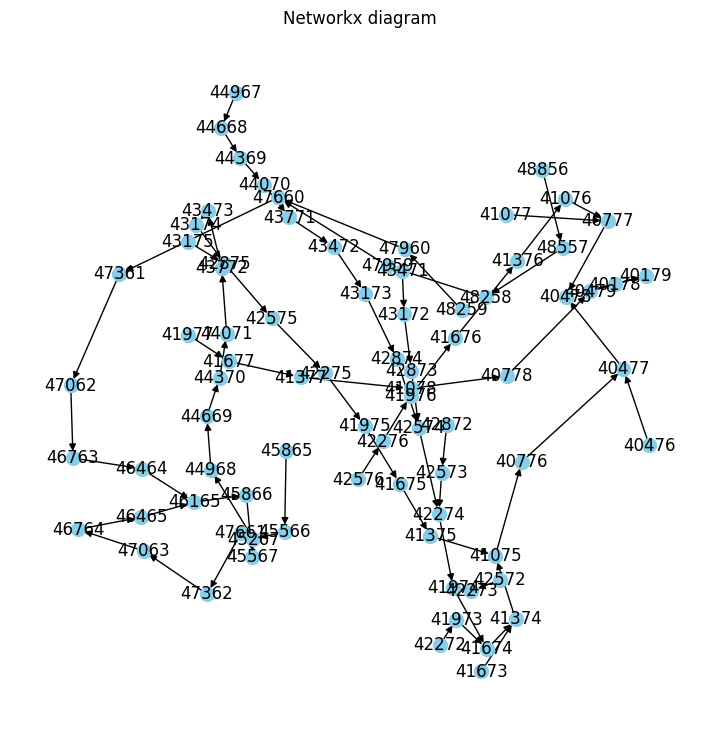

In [29]:
# simple tree visual
pitTree = big_trees[big_pits[0]]
plt.figure(figsize=(7,7))
# define layout for nodes
pos = nx.spring_layout(pitTree)
nx.draw(pitTree, pos, with_labels=True, node_color='skyblue', node_size=100, edge_color='k', arrows=True)
plt.title("Networkx diagram")
print(f'tree size: {pitTree.number_of_nodes()}')
plt.show()

Tree nodes: 80
Tree edges: 79
Tree nodes: 153
Tree edges: 152
Tree nodes: 83
Tree edges: 82
Tree nodes: 96
Tree edges: 95
Tree nodes: 52
Tree edges: 51
Tree nodes: 54
Tree edges: 53
Tree nodes: 68
Tree edges: 67
Tree nodes: 764
Tree edges: 763
Tree nodes: 66
Tree edges: 65
Tree nodes: 145
Tree edges: 144
Tree nodes: 217
Tree edges: 216
Tree nodes: 145
Tree edges: 144
Tree nodes: 73
Tree edges: 72
Tree nodes: 124
Tree edges: 123
Tree nodes: 57
Tree edges: 56
Tree nodes: 93
Tree edges: 92


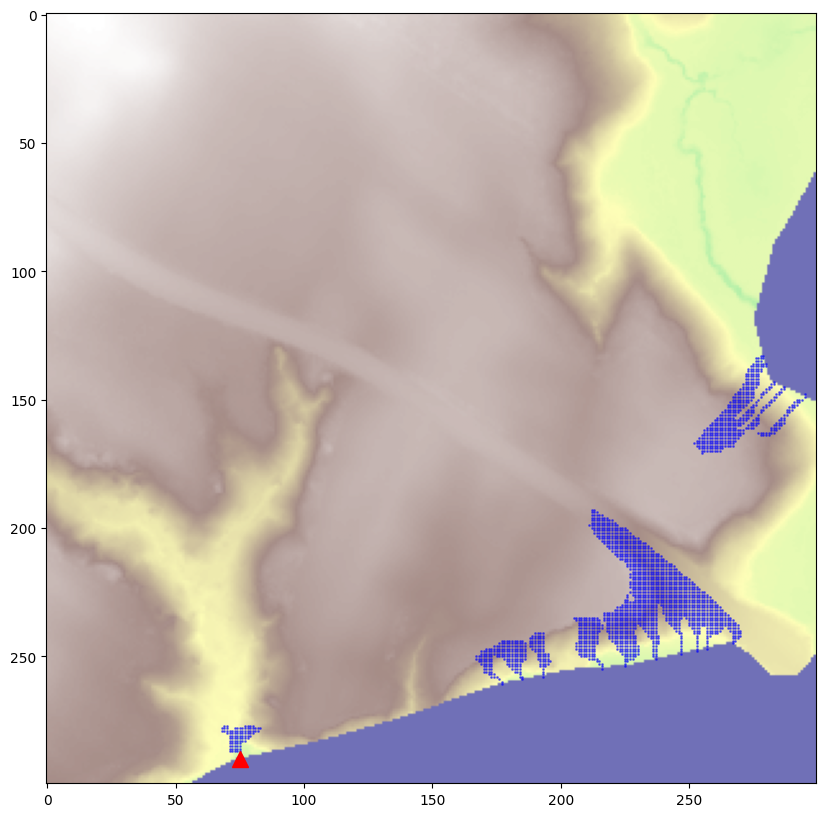

In [31]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(dem_data, cmap='terrain', alpha=0.7)


# Plot first 5 sources
for pit in big_pits:
    tree = big_trees[pit]
    # i is the pit index - brilliant use of dictionary instead of list

    print(f"Tree nodes: {tree.number_of_nodes()}")
    print(f"Tree edges: {tree.number_of_edges()}")
    
    
    for node in tree.nodes():
        r, c = tree.nodes[node]['dem_idx']
        ax.plot(c, r, 'bo', markersize=1, alpha=0.5)

    # Mark the pit
    pit_r, pit_c = tree.nodes[pit]['dem_idx']
ax.plot(pit_c, pit_r, 'r^', markersize=12)
plt.show()

In [38]:
max_elev = 0
for pit in big_pits:
    tree = big_trees[pit]
    mean_v = tree.nodes[pit]['mean_vel']
    print(f"mean vel: {mean_v:.3f}")
    for node in tree.nodes():
        
        node_elev = tree.nodes[node]['elev']
        if node_elev > max_elev:
            max_elev = node_elev

print(f"max elev in these trees is: {max_elev}")

mean vel: 0.005
mean vel: 0.005
mean vel: 0.005
mean vel: 0.005
mean vel: 0.005
mean vel: 0.022
mean vel: 0.022
mean vel: 0.025
mean vel: 0.025
mean vel: 0.025
mean vel: 0.029
mean vel: 0.029
mean vel: 0.017
mean vel: 0.014
mean vel: 0.014
mean vel: 0.015
max elev in these trees is: 11.294105529785156


#  flow path from a single source
def trace_proper_flow_path(graph, start_node):
    """
    Traces the flow path from a source node until it reaches a pit or dead end.
    
    Returns:
        path (list): List of node indices in the flow path
    """
    # source must be valid
    elev = graph.nodes[start_node]["elev"]
    if elev < 0:
        return

        
    path = [start_node]
    current = start_node
   

    while graph.out_degree(current) > 0 and elev >=0:  # While there's an outflow
        next_node = list(graph.successors(current))[0]  # Get the single downstream node
        path.append(next_node)
        elev = graph.nodes[next_node]["elev"]
        current = next_node
        
        # Safety check for cycles (shouldn't happen in proper flow graph)
        # if len(path) > height * width:
           # print("Warning: Cycle detected!")
           # break
    
    return path

# list of "proper" flows
properPathsList = []
for s in sourceList:
    path = trace_proper_flow_path(wolfGraph, s)
    properPathsList.append(path)

print(f"number of proper paths: {len(properPathsList)}")

In [ ]:
# Get the first source and trace its path
start_source = sourceList[902]
flow_path = trace_proper_flow_path(wolfGraph, start_source)

print(f"Flow path length: {len(flow_path)} nodes")
print(f"Starts at elevation: {wolfGraph.nodes[flow_path[0]]['elev']:.2f}m")
print(f"Ends at elevation: {wolfGraph.nodes[flow_path[-1]]['elev']:.2f}m")

# Plotting
fig, ax = plt.subplots(figsize=(12, 10))

# Hillshade background
ax.imshow(dem_data, cmap='terrain', alpha=0.7)

# Draw the flow path as connected line segments
path_coords = []
for node in flow_path:
    r, c = wolfGraph.nodes[node]['dem_idx']
    path_coords.append([c, r])  # Note: matplotlib uses (x, y) = (col, row)

path_coords = np.array(path_coords)
ax.plot(path_coords[:, 0], path_coords[:, 1], 
        'b-', linewidth=2, alpha=0.8, label='Flow Path')

# Mark start (source) and end (pit or outlet)
start_r, start_c = wolfGraph.nodes[flow_path[0]]['dem_idx']
end_r, end_c = wolfGraph.nodes[flow_path[-1]]['dem_idx']

ax.plot(start_c, start_r, 'go', markersize=12, label='Source', zorder=5)
ax.plot(end_c, end_r, 'r^', markersize=12, label='Outlet/Pit', zorder=5)
'''
# Add some intermediate points for reference
if len(flow_path) > 4:
    for i in [len(flow_path)//4, len(flow_path)//2, 3*len(flow_path)//4]:
        r, c = wolfGraph.nodes[flow_path[i]]['dem_idx']
        ax.plot(c, r, 'yo', markersize=6, alpha=0.7)
'''
ax.legend()
# ax.set_title(f"Single Flow Path (Source node {start_source})")
ax.set_xlabel("Column (pixels)")
ax.set_ylabel("Row (pixels)")
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(dem_data, cmap='terrain', alpha=0.7)


# Plot first 5 sources
for i, source in enumerate(sourceList[:1000]):
    path = trace_proper_flow_path(wolfGraph, source)
    path_coords = np.array([[wolfGraph.nodes[n]['dem_idx'][1], 
                             wolfGraph.nodes[n]['dem_idx'][0]] for n in path])
    ax.plot(path_coords[:, 0], path_coords[:, 1], color='k',
            linewidth=1.5, alpha=0.7, label=f'Path {i+1}')

ax.legend()
plt.show()